# Task A: Creating a Performance Predictor

In this task, you will use training data from 2000 configurations on a single OpenML dataset to train a performance predictor. The data will be splitted into train, test and validation set and we will only use the first 10 epochs of the learning curves for predicitons. You are provided with the full benchmark logs for Fashion-MNIST, that is learning curves, config parameters and gradient statistics, and you can use them freely.

For questions, you can contact zimmerl@informatik.uni-freiburg.

__Note: Please use the dataloading and splits you are provided with in this notebook.__

## Specifications:

* Data: fashion_mnist.json
* Number of datasets: 1
* Number of configurations: 2000
* Number of epochs seed during prediction: 10
* Available data: Learning curves, architecture parameters and hyperparameters, gradient statistics 
* Target: Final validation accuracy
* Evaluation metric: MSE

## Importing and splitting data

__Note__: There are 51 steps logged, 50 epochs plus the 0th epoch, prior to any weight updates.

In [200]:
%%capture
%cd ..
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import utils_prep
from api import Benchmark
import utils_prep2
import torch

In [201]:
bench_dir = "/home/sven/LCBench/data/11604705/fashion_mnist.json"
bench = Benchmark(bench_dir, cache=False)

==> Loading data...
==> No cached data found or cache set to False.
==> Reading json data...
==> Done.


In [202]:
# Read data
def cut_data(data, cut_position):
    targets = []
    for dp in data:
        targets.append(dp["Train/val_accuracy"][50])
        for tag in dp:
            if tag.startswith("Train/"):
                dp[tag] = dp[tag][0:cut_position]
    return data, targets

def read_data():
    dataset_name = 'Fashion-MNIST'
    n_configs = bench.get_number_of_configs(dataset_name)
    
    # Query API
    data = []
    for config_id in range(n_configs):
        data_point = dict()
        data_point["config"] = bench.query(dataset_name=dataset_name, tag="config", config_id=config_id)
        for tag in bench.get_queriable_tags(dataset_name=dataset_name, config_id=config_id):
            if tag.startswith("Train/"):
                data_point[tag] = bench.query(dataset_name=dataset_name, tag=tag, config_id=config_id)    
        data.append(data_point)
        
    # Split: 50% train, 25% validation, 25% test (the data is already shuffled)
    indices = np.arange(n_configs)
    ind_train = indices[0:int(np.floor(0.5*n_configs))]
    ind_val = indices[int(np.floor(0.5*n_configs)):int(np.floor(0.75*n_configs))]
    ind_test = indices[int(np.floor(0.75*n_configs)):]

    array_data = np.array(data)
    train_data = array_data[ind_train]
    val_data = array_data[ind_val]
    test_data = array_data[ind_test]
    
    # Cut curves for validation and test
    cut_position = 11
    val_data, val_targets = cut_data(val_data, cut_position)
    test_data, test_targets = cut_data(test_data, cut_position)
    train_data, train_targets = cut_data(train_data, 51)   # Cut last value as it is repeated
    
    return train_data, val_data, test_data, train_targets, val_targets, test_targets
    
train_data, val_data, test_data, train_targets, val_targets, test_targets = read_data()

print("Train:", len(train_data))
print("Validation:", len(val_data))
print("Test:", len(test_data))

Train: 1000
Validation: 500
Test: 500


The data contains the configuration of the trained model and learning curves as well as global and layer-wise gradient statistics.

__Note__: Not all parameters vary across different configurations. The varying parameters are batch_size, max_dropout, max_units, num_layers, learning_rate, momentum, weight_decay

In [203]:
# Config
print("Config example:", test_data[0]["config"])
print("\n")
print("DATA Keys:", test_data[0].keys())

Config example: {'batch_size': 93, 'imputation_strategy': 'mean', 'learning_rate_scheduler': 'cosine_annealing', 'loss': 'cross_entropy_weighted', 'network': 'shapedmlpnet', 'max_dropout': 0.06145480624960298, 'normalization_strategy': 'standardize', 'optimizer': 'sgd', 'cosine_annealing_T_max': 50, 'cosine_annealing_eta_min': 1e-08, 'activation': 'relu', 'max_units': 402, 'mlp_shape': 'funnel', 'num_layers': True, 'learning_rate': 0.07306153347321286, 'momentum': 0.5844418984083981, 'weight_decay': 0.05967268273584057}


DATA Keys: dict_keys(['config', 'Train/loss', 'Train/train_accuracy', 'Train/val_accuracy', 'Train/train_cross_entropy', 'Train/val_cross_entropy', 'Train/train_balanced_accuracy', 'Train/val_balanced_accuracy', 'Train/test_result', 'Train/test_cross_entropy', 'Train/test_balanced_accuracy', 'Train/gradient_max', 'Train/gradient_mean', 'Train/gradient_median', 'Train/gradient_std', 'Train/gradient_q10', 'Train/gradient_q25', 'Train/gradient_q75', 'Train/gradient_q90',

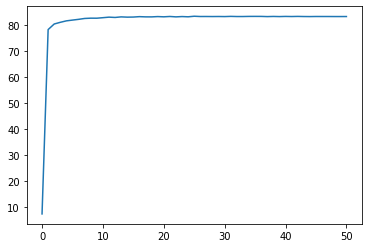

In [204]:
# Learning curve
plt.plot(train_data[10]["Train/val_accuracy"])

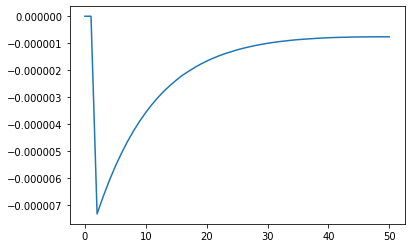

In [205]:
# Gradient statistics
plt.plot(train_data[10]["Train/layer_wise_gradient_mean_layer_0"])

In [206]:
device = utils_prep2.check_cuda()


In [207]:
class LSTM_Net(torch.nn.Module):
    
    def __init__(self, input_size, num_classes, embedding_dim, hidden_size, seq_length, 
                 num_layers, config_size, bidirectional = False, drop_prob=0.5, relative_size = 0.2):
        super(LSTM_Net, self).__init__()

        self.input_size = input_size
        self.hidden_dim = hidden_size
        self.seq_length = seq_length
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.config_size = config_size
        
        # self.forecaster = torch.nn.Embedding(100, embedding_dim)

        self.dropout = torch.nn.Dropout(drop_prob)
        self.lstm = torch.nn.LSTM(input_size = self.input_size, hidden_size = self.hidden_dim, 
                            num_layers = self.num_layers, dropout =drop_prob, bidirectional = bidirectional)
        
 
        
        self.linear1 = torch.nn.Linear(self.config_size, int(self.hidden_dim*relative_size))
                                       
                                       
        self.linear2 = torch.nn.Linear(int(self.hidden_dim*relative_size),
                                       int(self.hidden_dim*relative_size))
                                       
                                       
        self.linear3 = torch.nn.Linear(self.hidden_dim + int(self.hidden_dim*relative_size),
                                       self.hidden_dim + int(self.hidden_dim*relative_size))

        
        self.linear4 = torch.nn.Linear(self.hidden_dim + int(self.hidden_dim*relative_size), self.hidden_dim//2)
        
        self.linear5 = torch.nn.Linear(self.hidden_dim//2, num_classes)
        
        
        self.dropout2 = torch.nn.Dropout(drop_prob)
        
        
        self.linear_reduce1 = torch.nn.Linear(self.hidden_dim*10, self.hidden_dim*5)

        self.linear_reduce2 = torch.nn.Linear(self.hidden_dim*5, self.hidden_dim)

        self.linear_reduce3 = torch.nn.Linear(self.hidden_dim, self.hidden_dim)


    
    def forward(self, x, configs, hidden):
        
        batch_size = x.size(0)
        
        x = torch.t(x)

        x=x.unsqueeze(-1)
        
        x = x.float()
        
        #forecast = self.forecaster(x)

        lstm_x, hidden = self.lstm(x, hidden)
            
        lstm_x = lstm_x.permute(1,0,2)

        
        lstm_x = lstm_x.contiguous().view(batch_size, -1)
        


        # lstm_x = lstm_x.contiguous().view(-1, self.hidden_dim)
        
        x = self.dropout(lstm_x)
        
        # try 
        
        
        x = torch.nn.functional.relu(self.linear_reduce1(x))
        x = torch.nn.functional.relu(self.linear_reduce2(x))
        x = torch.nn.functional.relu(self.linear_reduce3(x))


                                       
        x_config = torch.nn.functional.relu(self.linear1(configs))
        x_config = torch.nn.functional.relu(self.linear2(x_config))

        x_cat =  torch.cat([x, x_config], dim =1)

        
        x_cat = torch.nn.functional.relu(self.linear3(x_cat))
        
        #x_cat = self.dropout2(x_cat)
        
        x_cat = torch.nn.functional.relu(self.linear4(x_cat))
        x_cat = self.linear5(x_cat)

        
        x_cat = x_cat.view(batch_size, -1)
        x_cat = x_cat[:,-1]
        
        return x_cat, hidden
    
    def init_hidden(self, batch_size = 32):
        
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))
    

In [208]:
### alternative weighted MSE Loss



def weighted_mse_loss(prediction, target, weight):
    ### construct weight vector
        
    
    
    return torch.sum((prediction-target)**2)




In [209]:
#### calculate weights

weights = [1/(len([x for x in train_targets if x < 80.0])), 1/(len([x for x in train_targets if x >= 80.0]))]


In [210]:
def create_model(hidden_dim, num_layers, input_size = 10, lr= 0.001, relative_size = 0.75, weight_decay = 0.001):
    input_size = 1
    outcome_dim = 1
    embedding_dim = 400
    seq_length = 10
    config_size = 7

    model = LSTM_Net(input_size, outcome_dim, embedding_dim, hidden_dim, seq_length, num_layers, config_size,
                     relative_size = relative_size)
    model.to(device)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
    
    return model, optimizer, criterion

In [211]:
def train_validate_model(model, optimizer, criterion):
    
    epochs = 2000
    counter = 0
    print_every = 200

    clip = 5
    valid_loss_min = np.Inf


    model.train()

    for i in range(epochs):


        for batches, configs , labels in train_data_loader:
            counter += 1

            batch_size_calc = len(labels)
            hidden = model.init_hidden(batch_size=batch_size_calc)


            model.zero_grad()

            output, hidden = model(batches, configs, hidden)


            loss = abs(criterion(output.squeeze(), labels.float()))
            loss.backward()


            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()


            if counter%print_every == 0:

                val_losses = []
                model.eval()

                for inp,configs, lab in val_data_loader:

                    batch_size_calc = len(lab)

                    val_h = model.init_hidden(batch_size = batch_size_calc)


                    val_h = tuple([each.data for each in val_h])
                    inp, lab = inp.to(device), lab.to(device)
                    out, val_h = model(inp, configs,val_h)
                    val_loss = abs(criterion(out.squeeze(), lab.float()))
                    val_losses.append(val_loss.item())

                    print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))

                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), '/home/sven/LCBench/state_dict.pt')
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                    valid_loss_min = np.mean(val_losses)
                
                model.train()


    return


In [212]:
def test_model(model, criterion):
    
    model.load_state_dict(torch.load('/home/sven/LCBench/state_dict.pt'))

    test_losses = []
    msqrt = 0
    counter = 0


    model.eval()
    for inputs,configs, labels in test_data_loader:
        counter = counter +1
        batch_size_calc = len(labels)
        h = model.init_hidden(batch_size_calc)
        inputs, labels = inputs.to(device), labels.to(device)
        output, h = model(inputs,configs, h)
        test_loss = criterion(output.squeeze(), labels.float())
        test_losses.append(test_loss.item())
        pred = (output.squeeze())

        msqrt = msqrt + mean_squared_error(labels.detach().numpy(), pred.detach().numpy())
    
        print((labels.detach()))
        print((pred.detach()))
    print(counter)
    total_test_acc = msqrt
    print("TOTAL Loss: {:.3f}".format(total_test_acc))
    test_acc2 = msqrt/counter
    
    print("Msqrt: {:.3f}".format(test_acc2))

    print("Test loss: {:.3f}".format(np.mean(test_losses)))
    
    return test_acc2, np.mean(test_losses)


In [213]:
from utils import prep_data



train_data_loader = prep_data(train_data, train_targets, batch_size = 32,first_n_epochs = 10 )
test_data_loader = prep_data(test_data, test_targets, batch_size = 32,first_n_epochs = 10 )
val_data_loader = prep_data(val_data, val_targets, batch_size = 32, first_n_epochs=10)


model, optimizer, criterion = create_model(50, 3, input_size = 10)
train_validate_model(model, optimizer, criterion)
    
    


Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 11.260777
Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 9.119049
Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 10.492034
Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 9.348111
Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 10.455791
Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 13.318169
Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 12.019214
Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 11.244556
Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 10.971863
Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 10.561783
Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 10.445814
Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 10.904299
Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 10.710390
Epoch: 7/2000... Step: 200... Loss: 18.971664... Val Loss: 11.413108
Epoch: 7/2000... Step: 200... Loss: 

Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 11.003328
Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 11.954572
Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 15.078635
Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 13.732626
Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 15.068315
Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 14.996149
Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 14.549915
Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 14.087809
Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 14.030524
Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 13.725020
Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 13.376948
Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 14.338558
Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 14.602130
Epoch: 57/2000... Step: 1800... Loss: 31.099972... Val Loss: 15.089789
Epoch:

Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 26.508224
Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 24.024890
Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 25.574373
Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 23.949897
Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 26.150722
Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 26.637222
Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 25.299293
Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 24.580237
Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 24.255930
Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 23.759118
Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 23.637895
Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 24.729748
Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 24.307368
Epoch: 107/2000... Step: 3400... Loss: 12.783144... Val Loss: 25

Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 6.998013
Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 5.929393
Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 7.841706
Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 6.670689
Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 7.670543
Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 7.799607
Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 7.078308
Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 6.615705
Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 6.533791
Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 6.292691
Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 6.150174
Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 6.867529
Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 6.873715
Epoch: 157/2000... Step: 5000... Loss: 16.158943... Val Loss: 7.495553
Epoch:

Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 6.947193
Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 7.422479
Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 10.250289
Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 8.735045
Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 10.223600
Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 11.106914
Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 10.286108
Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 9.666549
Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 9.410029
Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 9.096185
Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 8.796848
Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 9.822903
Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 9.882413
Epoch: 207/2000... Step: 6600... Loss: 10.354958... Val Loss: 10.399187
E

Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 7.557038
Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 6.427498
Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 8.358809
Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 7.282574
Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 8.079888
Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 8.184050
Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 7.528288
Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 7.109395
Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 7.031055
Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 6.796289
Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 6.646007
Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 7.251704
Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 7.254743
Epoch: 257/2000... Step: 8200... Loss: 12.611261... Val Loss: 7.867040
Epoch:

Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 6.017720
Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 5.563405
Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 7.808679
Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 6.392846
Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 7.800531
Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 7.411605
Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 6.626478
Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 6.149833
Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 5.943999
Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 5.770386
Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 5.522253
Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 6.713277
Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 6.650999
Epoch: 307/2000... Step: 9800... Loss: 7.237052... Val Loss: 7.285718
Epoch: 307/2000... S

Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 8.984810
Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 7.778167
Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 9.241178
Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 8.005197
Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 9.263447
Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 9.889417
Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 8.994275
Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 8.412443
Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 8.175263
Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 7.912016
Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 7.814806
Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 8.627539
Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 8.441921
Epoch: 357/2000... Step: 11400... Loss: 12.181624... Val Loss: 9

Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 6.106924
Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 5.804120
Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 6.734816
Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 5.822369
Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 6.672657
Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 6.774937
Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 6.148998
Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 5.766509
Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 5.610325
Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 5.419206
Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 5.283542
Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 5.926751
Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 5.900774
Epoch: 407/2000... Step: 13000... Loss: 4.712675... Val Loss: 6.403731
Epoch:

Epoch: 457/2000... Step: 14600... Loss: 20.687077... Val Loss: 19.229595
Epoch: 457/2000... Step: 14600... Loss: 20.687077... Val Loss: 19.508088
Epoch: 457/2000... Step: 14600... Loss: 20.687077... Val Loss: 20.513094
Epoch: 457/2000... Step: 14600... Loss: 20.687077... Val Loss: 19.679874
Epoch: 457/2000... Step: 14600... Loss: 20.687077... Val Loss: 19.585918
Epoch: 457/2000... Step: 14600... Loss: 20.687077... Val Loss: 18.692157
Epoch: 457/2000... Step: 14600... Loss: 20.687077... Val Loss: 18.697895
Epoch: 457/2000... Step: 14600... Loss: 20.687077... Val Loss: 18.779125
Epoch: 457/2000... Step: 14600... Loss: 20.687077... Val Loss: 18.806676
Epoch: 457/2000... Step: 14600... Loss: 20.687077... Val Loss: 19.063363
Epoch: 457/2000... Step: 14600... Loss: 20.687077... Val Loss: 19.300271
Epoch: 457/2000... Step: 14600... Loss: 20.687077... Val Loss: 19.670011
Epoch: 457/2000... Step: 14600... Loss: 20.687077... Val Loss: 19.903298
Epoch: 457/2000... Step: 14600... Loss: 20.687077..

Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 9.909952
Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 9.769280
Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 10.577637
Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 9.391629
Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 9.472520
Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 8.829481
Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 8.444715
Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 8.362728
Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 8.214001
Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 8.415536
Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 8.321130
Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 8.688982
Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 8.803811
Epoch: 507/2000... Step: 16200... Loss: 7.837017... Val Loss: 9.235842
Epoch

Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 6.605202
Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 6.254741
Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 7.029758
Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 5.891166
Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 6.793520
Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 6.733689
Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 6.069248
Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 5.707722
Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 5.530789
Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 5.331357
Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 5.179875
Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 5.870724
Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 5.784522
Epoch: 557/2000... Step: 17800... Loss: 5.096449... Val Loss: 6.337175
Epoch:

Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 5.556987
Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 5.429062
Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 5.854851
Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 5.011540
Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 5.970013
Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 5.937334
Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 5.357470
Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 5.062073
Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 4.926464
Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 4.772157
Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 4.696071
Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 5.477571
Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 5.449378
Epoch: 607/2000... Step: 19400... Loss: 2.853083... Val Loss: 5.990315
Epoch:

Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 6.328410
Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 6.252977
Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 7.247739
Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 5.826568
Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 6.936384
Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 6.714553
Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 5.947106
Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 5.581682
Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 5.338535
Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 5.227612
Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 5.014129
Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 5.844425
Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 5.818617
Epoch: 657/2000... Step: 21000... Loss: 2.788664... Val Loss: 6.435766
Epoch:

Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 5.002669
Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 5.296895
Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 5.774683
Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 4.943832
Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 6.168818
Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 5.892613
Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 5.333046
Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 5.108514
Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 4.900433
Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 4.703957
Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 4.597098
Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 5.490814
Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 5.474770
Epoch: 707/2000... Step: 22600... Loss: 3.132545... Val Loss: 5.886469
Epoch:

Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 6.389874
Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 6.073219
Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 6.441287
Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 5.581303
Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 6.823541
Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 6.953875
Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 6.263613
Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 5.859786
Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 5.662625
Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 5.466410
Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 5.382443
Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 6.315776
Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 6.188562
Epoch: 757/2000... Step: 24200... Loss: 4.056296... Val Loss: 6.741674
Epoch:

Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 5.567781
Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 5.613039
Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 5.864662
Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 4.946822
Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 6.042582
Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 6.107640
Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 5.477002
Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 5.143973
Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 4.973868
Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 4.816460
Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 4.725254
Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 5.550352
Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 5.473869
Epoch: 807/2000... Step: 25800... Loss: 4.270213... Val Loss: 5.973560
Epoch:

Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 8.969638
Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 9.858862
Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 10.620674
Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 9.176749
Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 9.608928
Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 9.155480
Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 8.646884
Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 8.450332
Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 8.211495
Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 8.082173
Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 7.852636
Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 8.434673
Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 8.515859
Epoch: 857/2000... Step: 27400... Loss: 6.300362... Val Loss: 8.921730
Epoch

Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 7.541636
Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 6.799582
Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 7.234077
Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 6.250169
Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 6.754314
Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 6.441212
Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 5.896522
Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 5.756598
Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 5.579849
Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 5.412972
Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 5.248873
Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 5.780307
Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 5.673793
Epoch: 907/2000... Step: 29000... Loss: 3.222414... Val Loss: 6.115272
Epoch:

Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 6.737012
Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 6.605983
Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 7.074867
Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 6.019095
Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 6.640362
Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 6.238561
Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 5.719869
Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 5.541618
Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 5.380660
Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 5.252982
Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 5.110811
Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 5.692895
Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 5.568213
Epoch: 957/2000... Step: 30600... Loss: 3.868709... Val Loss: 6.112190
Epoch:

Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 9.727832
Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 8.735134
Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 9.285856
Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 7.503828
Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 7.852363
Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 7.796173
Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 6.964989
Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 6.805531
Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 6.497725
Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 6.334990
Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 6.057682
Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 6.482179
Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 6.327531
Epoch: 1007/2000... Step: 32200... Loss: 9.164244... Val Loss: 6

Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 6.021425
Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 5.904737
Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 6.329686
Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 5.261439
Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 6.340252
Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 6.051026
Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 5.376964
Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 5.052372
Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 4.843182
Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 4.712753
Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 4.554462
Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 5.451314
Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 5.362338
Epoch: 1057/2000... Step: 33800... Loss: 3.711508... Val Loss: 5

Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 7.839473
Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 8.678975
Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 9.570820
Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 8.332085
Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 9.153397
Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 8.813928
Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 8.299075
Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 8.068176
Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 7.853780
Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 7.700954
Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 7.507226
Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 8.318542
Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 8.409655
Epoch: 1107/2000... Step: 35400... Loss: 5.802655... Val Loss: 8

Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 5.556385
Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 5.644516
Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 5.583509
Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 4.753359
Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 5.627693
Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 6.015826
Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 5.435722
Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 5.248738
Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 5.040652
Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 4.871179
Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 4.763041
Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 5.530306
Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 5.409770
Epoch: 1157/2000... Step: 37000... Loss: 2.684809... Val Loss: 5

Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 8.769723
Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 7.813331
Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 8.428600
Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 7.004393
Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 7.242471
Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 6.999276
Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 6.332524
Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 6.183741
Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 5.967544
Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 5.820723
Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 5.602823
Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 6.036429
Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 5.879508
Epoch: 1207/2000... Step: 38600... Loss: 7.843672... Val Loss: 6

Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 7.735302
Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 6.854627
Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 7.072953
Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 5.916886
Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 6.154076
Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 6.078377
Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 5.519606
Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 5.516479
Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 5.377917
Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 5.381147
Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 5.367366
Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 5.700265
Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 5.642737
Epoch: 1257/2000... Step: 40200... Loss: 3.363418... Val Loss: 5

Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 8.222459
Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 7.702070
Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 8.182317
Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 6.873415
Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 9.060513
Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 9.213473
Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 8.196120
Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 7.508931
Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 7.096603
Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 7.152784
Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 7.235038
Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 8.544240
Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 8.418796
Epoch: 1307/2000... Step: 41800... Loss: 3.500120... Val Loss: 8

Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 7.597291
Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 8.491403
Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 9.034255
Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 7.921287
Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 8.549638
Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 7.965400
Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 7.497963
Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 7.418513
Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 7.164087
Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 7.007860
Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 6.811699
Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 7.551612
Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 7.548053
Epoch: 1357/2000... Step: 43400... Loss: 6.453062... Val Loss: 7

Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 5.112628
Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 5.229059
Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 5.696143
Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 4.744402
Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 5.736180
Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 5.563574
Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 4.988594
Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 4.807001
Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 4.579459
Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 4.465857
Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 4.339871
Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 5.178207
Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 5.117389
Epoch: 1407/2000... Step: 45000... Loss: 2.693536... Val Loss: 5

Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 5.434168
Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 5.993136
Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 6.323663
Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 5.182928
Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 6.227516
Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 6.128296
Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 5.482810
Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 5.208621
Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 4.942243
Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 4.800891
Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 4.700244
Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 5.576935
Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 5.528009
Epoch: 1457/2000... Step: 46600... Loss: 2.971556... Val Loss: 5

Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 6.960152
Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 7.546156
Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 8.057009
Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 6.710049
Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 7.130538
Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 6.885722
Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 6.309746
Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 6.121549
Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 5.895046
Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 5.771608
Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 5.635968
Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 6.214103
Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 6.189894
Epoch: 1507/2000... Step: 48200... Loss: 7.645486... Val Loss: 6

Epoch: 1550/2000... Step: 49600... Loss: 3.760720... Val Loss: 6.883278
Epoch: 1557/2000... Step: 49800... Loss: 3.587266... Val Loss: 5.393198
Epoch: 1557/2000... Step: 49800... Loss: 3.587266... Val Loss: 6.167242
Epoch: 1557/2000... Step: 49800... Loss: 3.587266... Val Loss: 6.450012
Epoch: 1557/2000... Step: 49800... Loss: 3.587266... Val Loss: 5.342721
Epoch: 1557/2000... Step: 49800... Loss: 3.587266... Val Loss: 6.228806
Epoch: 1557/2000... Step: 49800... Loss: 3.587266... Val Loss: 5.944365
Epoch: 1557/2000... Step: 49800... Loss: 3.587266... Val Loss: 5.333044
Epoch: 1557/2000... Step: 49800... Loss: 3.587266... Val Loss: 5.077562
Epoch: 1557/2000... Step: 49800... Loss: 3.587266... Val Loss: 4.853594
Epoch: 1557/2000... Step: 49800... Loss: 3.587266... Val Loss: 4.721558
Epoch: 1557/2000... Step: 49800... Loss: 3.587266... Val Loss: 4.589960
Epoch: 1557/2000... Step: 49800... Loss: 3.587266... Val Loss: 5.417205
Epoch: 1557/2000... Step: 49800... Loss: 3.587266... Val Loss: 5

Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 5.378686
Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 5.471996
Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 5.572435
Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 4.589306
Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 5.564187
Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 5.332984
Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 4.799660
Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 4.615597
Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 4.417205
Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 4.365535
Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 4.378337
Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 5.094820
Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 5.002416
Epoch: 1607/2000... Step: 51400... Loss: 2.204118... Val Loss: 5

Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 4.788278
Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 5.644228
Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 5.390444
Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 4.308241
Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 5.507557
Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 5.351228
Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 4.727997
Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 4.468711
Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 4.222239
Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 4.209135
Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 4.187289
Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 5.028449
Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 4.963944
Epoch: 1657/2000... Step: 53000... Loss: 1.986523... Val Loss: 5

Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 6.566339
Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 6.397312
Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 6.291323
Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 5.558483
Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 6.926976
Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 6.750629
Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 6.202267
Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 6.016414
Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 5.822438
Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 5.672645
Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 5.595513
Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 6.618259
Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 6.419294
Epoch: 1707/2000... Step: 54600... Loss: 3.540291... Val Loss: 6

Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 5.167668
Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 6.094158
Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 6.291968
Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 5.181555
Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 6.097159
Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 5.946914
Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 5.404419
Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 5.254486
Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 4.992637
Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 4.875346
Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 4.812151
Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 5.633241
Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 5.560150
Epoch: 1757/2000... Step: 56200... Loss: 4.285389... Val Loss: 5

Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 6.523568
Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 6.611225
Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 6.592086
Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 5.625165
Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 7.209439
Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 7.016798
Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 6.213835
Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 5.723641
Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 5.446685
Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 5.376679
Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 5.323800
Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 6.104424
Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 5.972343
Epoch: 1807/2000... Step: 57800... Loss: 2.908753... Val Loss: 6

Epoch: 1857/2000... Step: 59400... Loss: 6.854161... Val Loss: 11.102675
Epoch: 1857/2000... Step: 59400... Loss: 6.854161... Val Loss: 12.796229
Epoch: 1857/2000... Step: 59400... Loss: 6.854161... Val Loss: 13.309634
Epoch: 1857/2000... Step: 59400... Loss: 6.854161... Val Loss: 12.235543
Epoch: 1857/2000... Step: 59400... Loss: 6.854161... Val Loss: 12.552217
Epoch: 1857/2000... Step: 59400... Loss: 6.854161... Val Loss: 11.821751
Epoch: 1857/2000... Step: 59400... Loss: 6.854161... Val Loss: 11.490803
Epoch: 1857/2000... Step: 59400... Loss: 6.854161... Val Loss: 11.875232
Epoch: 1857/2000... Step: 59400... Loss: 6.854161... Val Loss: 11.553527
Epoch: 1857/2000... Step: 59400... Loss: 6.854161... Val Loss: 11.446108
Epoch: 1857/2000... Step: 59400... Loss: 6.854161... Val Loss: 11.295264
Epoch: 1857/2000... Step: 59400... Loss: 6.854161... Val Loss: 12.081560
Epoch: 1857/2000... Step: 59400... Loss: 6.854161... Val Loss: 12.227691
Epoch: 1857/2000... Step: 59400... Loss: 6.854161..

Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 5.156871
Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 5.733949
Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 5.729310
Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 4.656637
Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 5.516213
Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 5.315805
Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 4.746913
Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 4.573996
Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 4.365469
Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 4.297092
Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 4.201524
Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 4.976639
Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 4.864158
Epoch: 1907/2000... Step: 61000... Loss: 2.010924... Val Loss: 5

Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 5.637792
Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 5.817828
Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 5.744976
Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 4.686036
Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 5.808572
Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 5.589281
Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 4.988222
Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 4.740626
Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 4.509959
Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 4.446635
Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 4.371997
Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 5.205474
Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 5.078484
Epoch: 1957/2000... Step: 62600... Loss: 2.254097... Val Loss: 5

In [214]:
test_acc, msqrt = test_model(model, criterion)


tensor([83.5056, 81.3736, 80.0233, 81.2056, 83.1180, 81.3025, 84.1388, 80.9148,
        84.1646, 70.7779, 59.4650, 70.4419, 81.4640, 80.5401, 82.1489, 83.8610,
        81.8969, 59.4327, 79.8294, 83.2860, 83.6607, 78.5890, 71.3012, 75.5847,
        51.6346, 73.3687, 78.2272, 81.9421, 81.5157, 82.1166, 76.8510, 81.7095])
tensor([82.7910, 81.6401, 80.0444, 82.3157, 83.9442, 81.3170, 84.2825, 80.9289,
        82.9997, 72.6544, 56.7210, 69.6633, 81.9440, 78.5815, 81.5258, 82.3043,
        82.1150, 66.5303, 80.4695, 83.8613, 83.0810, 80.2495, 69.2251, 76.0652,
        60.7655, 74.2313, 80.1827, 82.6443, 81.2971, 82.9368, 79.8167, 82.6443])
tensor([82.3298, 83.9643, 59.0322, 83.9191, 84.3455, 84.1840, 80.6177, 84.4812,
        80.9665, 82.7756, 84.0871, 82.8983, 83.1890, 78.0204, 88.0346, 84.0806,
        83.8351, 82.6916, 89.1717, 80.6952, 68.0062, 77.3679, 72.8195, 84.2938,
        83.0727, 84.6233, 74.5768, 83.2472, 84.1194, 82.5688, 82.0390, 83.3247])
tensor([82.1462, 84.5968, 55.5063, 82

382
618


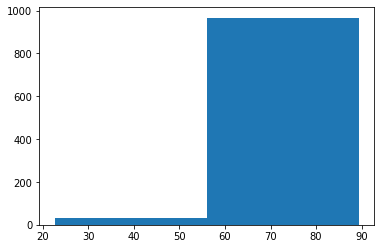

In [215]:
import matplotlib.pyplot as plt


print(len([x for x in train_targets if x < 80.0]))
print(len([x for x in train_targets if x > 80.0]))


plt.hist(train_targets,bins=2)
plt.show()


In [216]:
import pickle
import logging

from hpbandster.core.worker import Worker
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB

logging.getLogger('hpbandster').setLevel(logging.DEBUG)



/home/sven/.pyenv/versions/3.7.0/envs/ceat/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [217]:
class PyTorchWorker(Worker):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.train_loader, self.validation_loader, self.test_loader =\
            load_mnist_minibatched(batch_size=32, n_train=4096, n_valid=512)

    @staticmethod
    def get_model(config: CS.Configuration) -> nn.Module:
        """ Define a configurable convolution model.
            
        See description of get_conv_model above for more details on the model.
        """
        # START TODO ################ (1point)
        # raise NotImplementedError  
        
        hidden_dim = config['hidden_dim']
        num_layers = config['num_layers']
        
        model, optimizer, criterion = create_model(hidden_dim, num_layers, 
                                                   input_size = 10, lr= 0.001, relative_size = 0.75, weight_decay = 0.001)
        return model
    
    
    
    
        # END TODO ################
        
    @staticmethod
    def get_configspace() -> CS.Configuration:
        """ Define a conditional hyperparameter search-space.
    
        hyperparameters:
          num_filters_1   from    4 to   32 (int)
          num_filters_2   from    4 to   32 (int)
          num_filters_3   from    4 to   32 (int)
          num_conv_layers from    1 to    3 (int)
          lr              from 1e-6 to 1e-1 (float, log)
          sgd_momentum    from 0.00 to 0.99 (float)
          optimizer            Adam or  SGD (categoric)
          
        conditions: 
          include num_filters_2 only if num_conv_layers > 1
          include num_filters_3 only if num_conv_layers > 2
          include sgd_momentum  only if       optimizer = SGD
        """
        # START TODO ################ (2points)
        #raise NotImplementedError
        cs = CS.ConfigurationSpace()
        
        
        num_layers_cs = CSH.UniformIntegerHyperparameter("num_layers",lower=1,upper=5)
        hidden_dim_cs = CSH.UniformIntegerHyperparameter("num_layers",lower=5,upper=70)
        
        lr = CSH.UniformFloatHyperparameter("lr",lower=1e-6,upper=1e-1,log=True)
        weight_decay = CSH.UniformFloatHyperparameter("weight_decay",lower=1e-6,upper=1e-1,log=True)
        relative_size = CSH.UniformFloatHyperparameter("relative_size",lower=0.1,upper=3.0)
        sgd_momentum = CSH.UniformFloatHyperparameter("sgd_momentum",lower=0.00,upper=0.99)
        optimizer = CSH.CategoricalHyperparameter('optimizer', choices=['Adam', 'SGD'])
        
        
        cs.add_hyperparameters([num_layers_cs, hidden_dim_cs, weight_decay, lr, relative_size, sgd_momentum, optimizer])
    
        condition3 = CS.EqualsCondition(sgd_momentum,optimizer,'SGD')
        cs.add_condition(condition3)
        return cs
        # END TODO ################

    def compute(self, config: CS.Configuration, budget: float, working_directory: str,
                *args, **kwargs) -> dict:
        """Evaluate a function with the given config and budget and return a loss.
        
        Bohb tries to minimize the returned loss.
        
        In our case the function is the training and validation of a model,
        the budget is the number of epochs and the loss is the validation error.
        """
        model = self.get_model(config)
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        # START TODO ################ (3points)
        #raise NotImplementedError
        criterion = torch.nn.CrossEntropyLoss()
        if config['optimizer'] == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
        else:
                optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=config['sgd_momentum'])

        for epoch in range(int(budget)):
          loss = 0
          model.train()
          for i, (x, y) in enumerate(self.train_loader):
            optimizer.zero_grad()
            output = model(x)
            loss = F.nll_loss(output, y)
            loss.backward()
            optimizer.step()
        # END TODO ################
        
        train_accuracy = evaluate_accuracy(model, self.train_loader)
        validation_accuracy = evaluate_accuracy(model, self.validation_loader)
        test_accuracy = evaluate_accuracy(model, self.test_loader)
        
        return ({
                'loss': 1 - validation_accuracy,  # remember: HpBandSter minimizes the loss!
                'info': {'test_accuracy': test_accuracy,
                         'train_accuracy': train_accuracy,
                         'valid_accuracy': validation_accuracy,
                         'model': str(model)}
                })

   

NameError: name 'CS' is not defined

## A simple baseline

In [ ]:
class SimpleLearningCurvePredictor():
    """A learning curve predictor that predicts the last observed epoch of the validation accuracy as final performance"""
    
    def __init__(self):
        pass
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        predictions = []
        for datapoint in X:
            predictions.append(datapoint["Train/val_accuracy"][-1])
        return predictions
    
def score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [ ]:
# Training & tuning
predictor = SimpleLearningCurvePredictor()
for data in train_data:
    data['Train/val_accuracy']=data['Train/val_accuracy'][0:10]

predictor.fit(train_data, train_targets)
preds = predictor.predict(val_data)
mse = score(val_targets, preds)
print("Score on validation set:", mse)

In [ ]:
# Final evaluation (after tuning)
final_preds = predictor.predict(test_data)
final_score = score(test_targets, final_preds)
print("Final test score:", final_score)